<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/AppliedMachineLearning/AppliedMachineLearning_Week7_CNN_assignment_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# CS4305TU: Week 7 - Convolutional Neural Networks - Assignment
## Renote sensing classification using CNNs
*14 & 18 Nov 2021*

*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)

---


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import cv2
import h5py
from IPython import display
%matplotlib inline

In [ ]:
# Some variables for all cells
epochs = 5

# Q1-3: classification of the eurosat dataset

In [ ]:
import tensorflow_datasets as tfds
ds_train, info = tfds.load('eurosat/rgb', split='train[:75%]', as_supervised=True, shuffle_files=True, with_info=True)
ds_val, info = tfds.load('eurosat/rgb', split='train[75%:]', as_supervised=True, shuffle_files=False, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete2UGZXT/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


## Q1.1: ANN
 - `[code]` build a classical ANN to classify these Eurosat images with the following characteristics (where `FC[x,y]` = fully-connected layers with `x` neurons and `y` activation): `input->FC[100, relu]->FC[100, relu]->FC[10]` and train it for 10 epochs to classify eurosat dataset.
 

In [ ]:
ds_train = ds_train.cache()
ds_train = ds_train.batch(128)
ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.batch(128)
ds_val = ds_val.cache()
ds_val.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.uint8, tf.int64)>

In [ ]:
n_classes = 10

# building a linear stack of layers with the sequential model
model = tf.keras.models.Sequential()
# Flatten input layer
model.add(tf.keras.layers.Flatten(input_shape=(64,64,3)))
# hidden layer
model.add(tf.keras.layers.Dense(100, activation='relu'))
# hidden layer
model.add(tf.keras.layers.Dense(10, activation='relu'))
# output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# looking at the model summary
model.summary()
# compiling the sequential model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'], optimizer='adam')
# training the model for 10 epochs
ann = model.fit(ds_train, batch_size=128, epochs=epochs, validation_data=ds_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1228900   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 1,230,020
Trainable params: 1,230,020
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
159/159 [==============================] - 10s 46ms/step - loss: 21.9838 - accuracy: 0.1120 - val_loss: 2.2992 - val_accuracy: 0.1107
Epoch 2/5
159/159 [==============================] - 1s 6ms/step - loss: 2.2987 - accuracy: 0.1113 -

- `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for both training and validation datasets
 

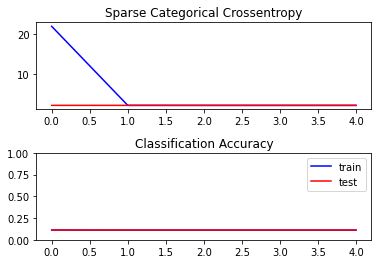

In [ ]:
# plot loss
plt.subplot(211)
plt.title('Sparse Categorical Crossentropy')
plt.plot(ann.history['loss'], color='blue', label='train')
plt.plot(ann.history['val_loss'], color='red', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(ann.history['accuracy'], color='blue', label='train')
plt.plot(ann.history['val_accuracy'], color='red', label='test')
plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

- `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
 

Size of pred_batch (128, 10)
Size of pred_batch (128,)
Size of pred_batch_prob (128,)


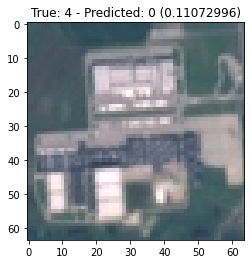

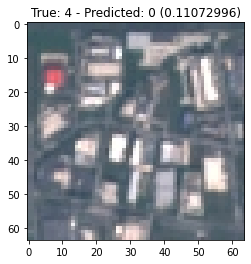

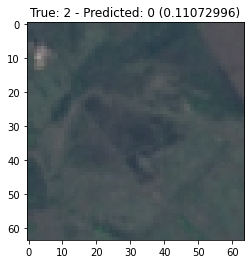

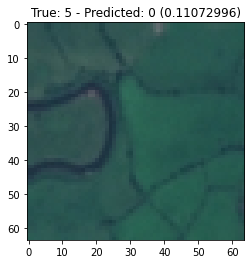

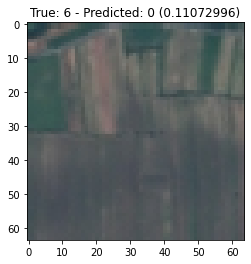

In [ ]:
# Get a batch of validation data 
get_batch = ds_val.take(1)
# Convert it to a numpy iterator
get_batch_np = list(get_batch.as_numpy_iterator())
# Do prediction
pred_batch = model.predict(get_batch,batch_size=128)
print('Size of pred_batch',pred_batch.shape)
pred_batch_max = np.argmax(pred_batch,axis=1) # Get the cell with the maximum prediction
print('Size of pred_batch',pred_batch_max.shape)
pred_batch_max_prob = pred_batch[:,pred_batch_max[0]] # Get the maximum probability
print('Size of pred_batch_prob',pred_batch_max_prob.shape)
for i in range(5):
  im = get_batch_np[0][0][i,:,:,:]
  label = get_batch_np[0][1][i]
  pred_label = pred_batch_max[i]
  pred_prob = pred_batch_max_prob[i]
  plt.figure()
  plt.imshow(im)
  plt.title('True: '+np.str(label)+' - Predicted: '+np.str(pred_label)+' ('+np.str(pred_prob)+')')#   print(i)

- `[text]` shortly (max 5 sentences) explain which loss function you implemented for training the network and why

  
> * We use `.SparseCategoricalCrossentropy()`, because this is the classifier needed if the provided label are of two or more label classes and provided as integers. 
* Since the output of the Dense last layer is activated with softmax we may assume assume that y_pred encodes a probability distribution (`from_logits=False` which is default)
* For TA's: if output layer is `model.add(tf.keras.layers.Dense(10))` instead of `model.add(tf.keras.layers.Dense(10, activation='softmax'))`, students should put `from_logits=False`, but you should also see it in the performance of the model.






## Q2.1: CNN
* `[code]` build a CNN to classify these Eurosat images during 5 epochs with the following characteristics where:
 *  `CNN[x*x,y,z,pad, act]` = Conv2D layers with a `x*x` kernel size, `y` filters, `z` stride, `pad` padding and `act` activation) 
 * `MaxPool[x*x,pad]`: MaxPool layer with a `x*x` pool_size and `pad` padding
 * `input -> block 1 -> block 2 -> block 3 -> FC block`, where
   * Block 1: `CNN[5*5,25,1,'same','relu]->MaxPool[2*2,'same']`
   * Block 2: `CNN[5*5,50,1,'same','relu]->CNN[3*3,50,1,'same','relu]->MaxPool[2*2,'same']`
   * Block 3: `CNN[3*3,70,2,'same','relu]->CNN[3*3,50,1,'same','relu]->MaxPool[2*2,'same']`
   * FC block: `FC[100, relu]->FC[10, relu]->FC[10]`

In [ ]:
## build a sequential model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(64,64,3)))

# 1st conv block
model.add(tf.keras.layers.Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
# model.add(tf.keras.layers.Conv2D(25, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
# 2nd conv block
model.add(tf.keras.layers.Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(tf.keras.layers.Conv2D(50, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.BatchNormalization())
# 3rd conv block
model.add(tf.keras.layers.Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(tf.keras.layers.Conv2D(50, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.BatchNormalization())
# ANN block
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.25))
# output layer
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

# compiling the sequential model
# model.compile(loss='CategoricalCrossentropy', metrics=['accuracy'], optimizer='adam')
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
cnn = model.fit(ds_train, batch_size=128, epochs=epochs, validation_data=ds_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 25)        1900      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 25)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 25)        100       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 50)        31300     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 50)        22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 50)       

* `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for both training and validation datasets for both the ANN (Q1.1)and CNN (Q2.1)


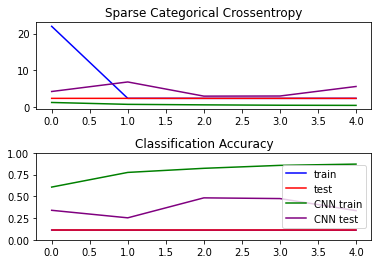

In [ ]:
plt.subplot(211)
plt.title('Sparse Categorical Crossentropy')
plt.plot(ann.history['loss'], color='blue', label='ANN train')
plt.plot(ann.history['val_loss'], color='red', label='ANN test')
plt.plot(cnn.history['loss'], color='green', label='CNN train')
plt.plot(cnn.history['val_loss'], color='purple', label='CNN test')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(ann.history['accuracy'], color='blue', label='train')
plt.plot(ann.history['val_accuracy'], color='red', label='test')
plt.plot(cnn.history['accuracy'], color='green', label='CNN train')
plt.plot(cnn.history['val_accuracy'], color='purple', label='CNN test')

plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

* `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model


Size of pred_batch (128, 10)
Size of pred_batch (128,)
Size of pred_batch_prob (128,)


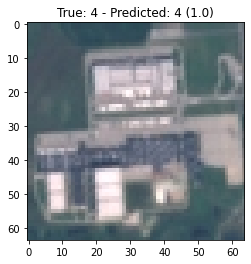

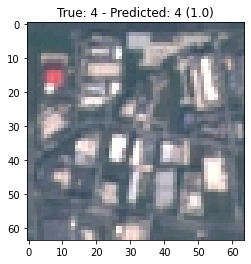

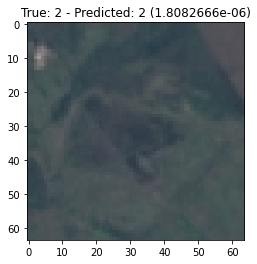

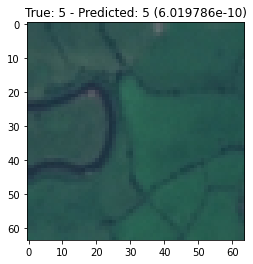

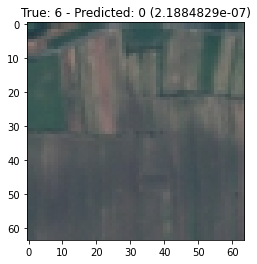

In [ ]:
# Get a batch of validation data 
get_batch = ds_val.take(1)
# Convert it to a numpy iterator
get_batch_np = list(get_batch.as_numpy_iterator())
# Do prediction
pred_batch = model.predict(get_batch,batch_size=128)
print('Size of pred_batch',pred_batch.shape)
pred_batch_max = np.argmax(pred_batch,axis=1) # Get the cell with the maximum prediction
print('Size of pred_batch',pred_batch_max.shape)
pred_batch_max_prob = pred_batch[:,pred_batch_max[0]] # Get the maximum probability
print('Size of pred_batch_prob',pred_batch_max_prob.shape)
for i in range(5):
  im = get_batch_np[0][0][i,:,:,:]
  label = get_batch_np[0][1][i]
  pred_label = pred_batch_max[i]
  pred_prob = pred_batch_max_prob[i]
  plt.figure()
  plt.imshow(im)
  plt.title('True: '+np.str(label)+' - Predicted: '+np.str(pred_label)+' ('+np.str(pred_prob)+')')#   print(i)

* `[text]` shortly discuss the difference between the ANN and CNN in terms of accuracy, learning rate, and difference in architecture (e.g. number of trainable parameters, layers, ...)


> * CNN learns faster and with higher accuracy
* CNN has only ~200k trainable parameters vs. 1.2M for ANN
* This difference in parameters is the result of the conv2d+pooling layer that reduce the input values to the FC network at the end of the chain

>  Note 1: results may differ depending on their integration of batch normalization (see also later). Both with/without batch normalization is correct here, but will off course affect the resulting learning rate/accuracy. If using `FC[10, relu]` with no batch normalization, the performance will be low but should not be a problem here.

> Note 2: there was an error in the assignment in the dense layer: 
`FC[100, relu]->FC[10, relu]->FC[10]`
Should have been
 `FC[100, relu]->FC[100, relu]->FC[10]`
 This will increase the absolute accuracy, but does not impact rest of the assignment interpretation.




* `[text]` shortly discuss what would be the effect of replacing the `5*5` kernel sizes of block 1+2 by a sequence of 2 `3*3` filters in terms of receptive fields and trainable parameters

> Replacing a 5x5 filter by a sequence of 3x3 filters results in the same receptive field (intregating features over a 5x5 input into 1 output) but with less trainable parameters (5*5=25 weights for 5x5, vs. 2*3*3= weights for the 3x3)

* `[text]` shortly discuss what would be the effect of batch normalisation at the end of every block on generalization and overfitting

> * Batch normalization  results here in faster training with better accuracy after 10 epochs (i.e. here `val_accuracy` of 73% (with) and )
* Batch generalization should result in higher generalization as they become less sensitive to the initial random weights and configuration of the learning algorithm
* It should stabilize the learning process and reduce the number of training epochs required to train deep networks.
* Batch Normalization reduces the instability in distributions of layer activations in deeper networks and therefore can reduce the effect of overfitting 

## Q3.1: Transfer learning
* `[code]` use transfer learning as a feature extraction by loading the VGG16 and ResNet50 models with fixed weights and by adding a `FC[100, relu]->FC[100, relu]->FC[10]` at the end. Use these models to again train/validate the `eurosat/rgb` dataset during 10 epochs.


In [ ]:
# Load Resnet model
new_input = tf.keras.Input(shape=(64, 64, 3))
resnet50 = tf.keras.applications.ResNet50(include_top=False, input_tensor=new_input)
for layer in resnet50.layers[0:-1]:
	layer.trainable = False

# add new classifier layers
flat1 = tf.keras.layers.Flatten()(resnet50.layers[-1].output)
class1 = tf.keras.layers.Dense(100, activation='relu')(flat1)
class2 = tf.keras.layers.Dense(10, activation='relu')(class1)
output = tf.keras.layers.Dense(10)(class2)

# define new model
resnet50 = tf.keras.Model(inputs=resnet50.inputs, outputs=output)
# for layer in resnet50.layers[-3:]:
# 	layer.trainable = True
resnet50.summary()

# Compile model
resnet50.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer='adam')
# fit on data for 30 epochs
rv = resnet50.fit(ds_train, epochs=epochs, batch_size=128, validation_data=ds_val)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Load VGG16 model
new_input = tf.keras.Input(shape=(64, 64, 3))
vgg16 = tf.keras.applications.VGG16(include_top=False, input_tensor=new_input)
for layer in vgg16.layers[0:-1]:
	layer.trainable = False

# add new classifier layers
flat1 = tf.keras.layers.Flatten()(vgg16.layers[-1].output)
class1 = tf.keras.layers.Dense(100, activation='relu')(flat1)
class2 = tf.keras.layers.Dense(10, activation='relu')(class1)
output = tf.keras.layers.Dense(10)(class2)
# define new model
vgg16 = tf.keras.Model(inputs=vgg16.inputs, outputs=output)
for layer in vgg16.layers[-3:]:
	layer.trainable = True
vgg16.summary()

# Compile model
vgg16.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer='adam')
# fit on data for 30 epochs
vv = vgg16.fit(ds_train, epochs=epochs, batch_size=128, validation_data=ds_val)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

* `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for your CNN of Q2.1 and the VGG16, Resnet.


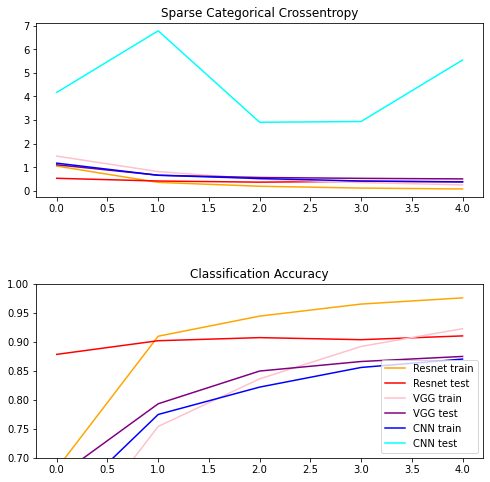

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.title('Sparse Categorical Crossentropy')
plt.plot(rv.history['loss'], color='orange', label='Resnet train')
plt.plot(rv.history['val_loss'], color='red', label='Resnet test')
plt.plot(vv.history['loss'], color='pink', label='VGG train')
plt.plot(vv.history['val_loss'], color='purple', label='VGG test')
plt.plot(cnn.history['loss'], color='blue', label='CNN train')
plt.plot(cnn.history['val_loss'], color='cyan', label='CNN test')


# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(rv.history['accuracy'], color='orange', label='Resnet train')
plt.plot(rv.history['val_accuracy'], color='red', label='Resnet test')
plt.plot(vv.history['accuracy'], color='pink', label='VGG train')
plt.plot(vv.history['val_accuracy'], color='purple', label='VGG test')
plt.plot(cnn.history['accuracy'], color='blue', label='CNN train')
plt.plot(cnn.history['val_accuracy'], color='cyan', label='CNN test')

plt.ylim(0.7,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

* `[text]` shortly discuss the difference between the your CNN and the tranfer models in terms of accuracy, learning rate, and difference in architecture (e.g. number of trainable parameters, layers, ...). 


> * the pre-trained networks learn much faster than our own CNN and show also  higher accuracy after 10 epochs. Especially the Resnet50 outperforms the others with accuracies of >90% after only 1 epoch.
*  this difference between pre-trained and own model can be explained by the more complex architecture where Resnet shows many trainable parameters that learn image features but that need many labels to train them
* this difference between pre-trained and own model can also be explained by batch normalization for example (which we did not have in our own CNN) which should result in more generalization and less overfitting


* `[text]` shortly discuss the (dis-)advantages of each model


> * Resnet is powerful by the complex architecture but is difficult to train (which is not important when we fix the weights)
* A pre-trained VGG is simpler (14M vs 23M paramters) but yet still powerfull as we can use the pre-trained features for better and faster learning

* `[code]` repeat the transfer learning by loading the architecture of the ResNet50 model but without fixing the weights. 

In [ ]:
# Load Resnet model
new_input = tf.keras.Input(shape=(64, 64, 3))
resnet50 = tf.keras.applications.ResNet50(include_top=False, input_tensor=new_input)
# add new classifier layers
flat1 = tf.keras.layers.Flatten()(resnet50.layers[-1].output)
class1 = tf.keras.layers.Dense(100, activation='relu')(flat1)
class2 = tf.keras.layers.Dense(10, activation='relu')(class1)
output = tf.keras.layers.Dense(10)(class2)

# define new model
resnet50 = tf.keras.Model(inputs=resnet50.inputs, outputs=output)
for layer in resnet50.layers:
	layer.trainable = True
resnet50.summary()

# Compile model
resnet50.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer='adam')
# fit on data for 30 epochs
rv2 = resnet50.fit(ds_train, epochs=epochs, batch_size=128, validation_data=ds_val)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

* `[text]` you can abort this free weights run early if it takes too long, but what can you learn about the (preliminary) accuracy and training time? Shortly discuss the effect of (not) fixing the weights in terms of accuracy, learning rate, computing time.


> * Re-training the weights requires much larger computing resources (> double of computing time) and with a lower accuracy.
* Retraining results in larger overfitting with bigger difference between train/test accuracy
* Retraining requires way more trainable parameters (~23M instead of ~820k), which results in much slower learning
* Architecture stays the same and we basically only copy the architecture and not the weights

# Q4: instance segmentation using a U-net

In step 4, we ask you to do a U-net classification on a set of [Landsat-8 imagery downloaded from the Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en). The data can be found on Brightspace in the Assignment Data section of `Content/week 7`. It contains of a tensorflow datarecord format which can be read using the following preprocessing (which you should not worry about for this assignment)

In [ ]:
# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']
BANDS = opticalBands + thermalBands
RESPONSE = 'impervious' 
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [ ]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

BUFFER_SIZE = 2000
BATCH_SIZE = 16

To load the data, you just need to specify the correct folder/filename in colab. We recommend to mount your google drive (where you can store the data) to easily load the data:

In [ ]:
# this mounts your Google Drive to the Colab VM and will ask you to authenticate
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# For training
gdrive_filename_training = '/content/drive/MyDrive/fcnn-demo-SL_training_patches_g0.tfrecord.gz'
dataset = get_dataset(gdrive_filename_training)
training = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# For evaluation
gdrive_filename_eval = '/content/drive/MyDrive/fcnn-demo-SL_eval_patches_g0.tfrecord.gz'
dataset = get_dataset(gdrive_filename_eval)
validation = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

You can now load and visualize that data (e.g. band 3 ([Band 3 (green) surface reflectance](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en#bands)) or the RGB bands which are bands 1:4 in reversed order as the satellite gives us BGR and we need RGB) with:

In [ ]:
temp = training.take(1).as_numpy_iterator()

In [ ]:
for i in temp:
  im = i[0][0][:,:,:]
  rgb = np.flip(i[0][0][:,:,1:4],axis=2) # take band 1:4 and flip it from BGR to RGB
  lb = i[1][0][:,:,0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


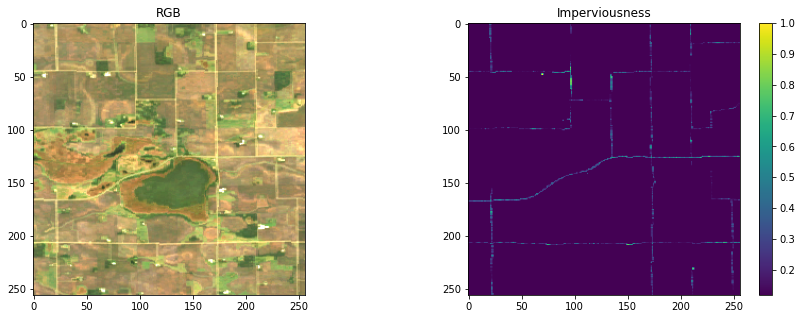

In [ ]:
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  i1 = axs[0].imshow(rgb*10)
  axs[0].set_title('RGB')
  i2= axs[1].imshow(lb)
  axs[1].set_title('Imperviousness')
  plt.colorbar(i1)

## Q4.1: homemade U-net

 * `[code]` build a U-net to these Landsat images for imperviousness during 10 epochs. You can copy the structure of the example notebook.
 

In [ ]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers
from keras.callbacks import ModelCheckpoint

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def unet():
	inputs = layers.Input(shape=[None, None, 9]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])
 
	model.compile(
		optimizer='SGD', 
		loss='MeanSquaredError',
		metrics=['RootMeanSquaredError'])

	return model

um = unet()
um.summary()
umm = um.fit(
    training, 
		batch_size=16,
		epochs=epochs, 
    validation_data=validation)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, None, None, 3 2624        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, None, None, 3 128         conv2d_69[0][0]                  
__________________________________________________________________________________________________
activation_81 (Activation)      (None, None, None, 3 0           batch_normalization_81[0][0]     
____________________________________________________________________________________________

* `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for U-net
 

In [ ]:
umm.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

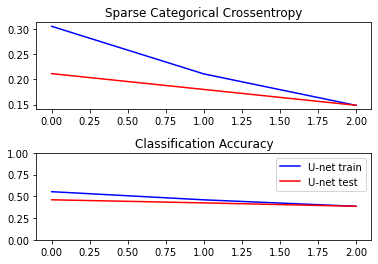

In [ ]:
plt.subplot(211)
plt.title('Loss MeanSquaredError')
plt.plot(umm.history['loss'], color='blue', label='U-net train')
plt.plot(umm.history['val_loss'], color='red', label='U-net test')

# plot accuracy
plt.subplot(212)
plt.title('Classification RMSE')
plt.plot(umm.history['root_mean_squared_error'], color='blue', label='U-net train')
plt.plot(umm.history['val_root_mean_squared_error'], color='red', label='U-net test')

plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

* `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
 

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


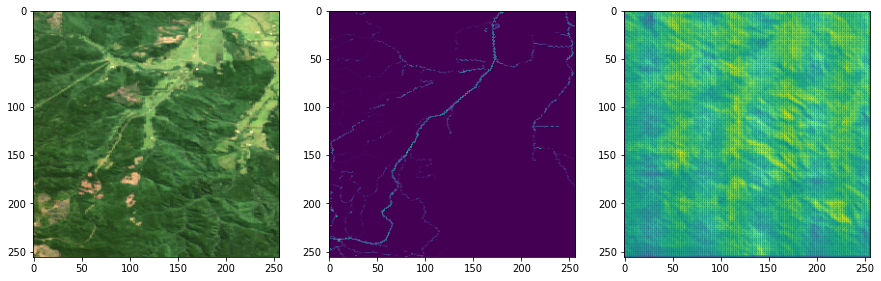

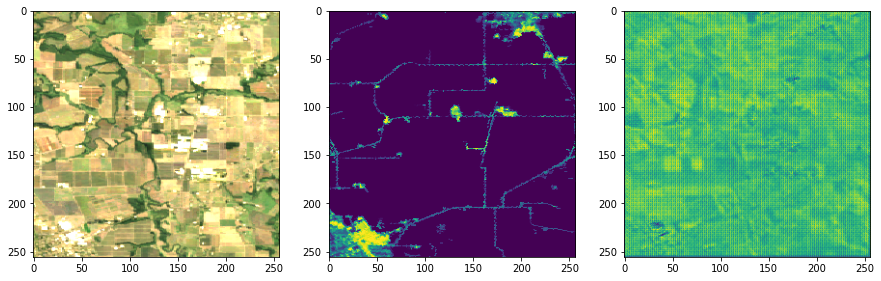

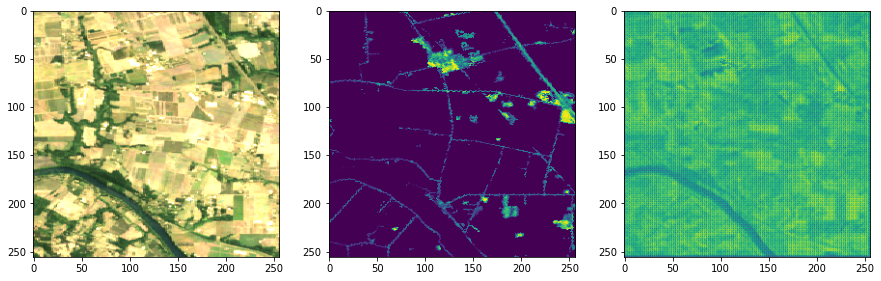

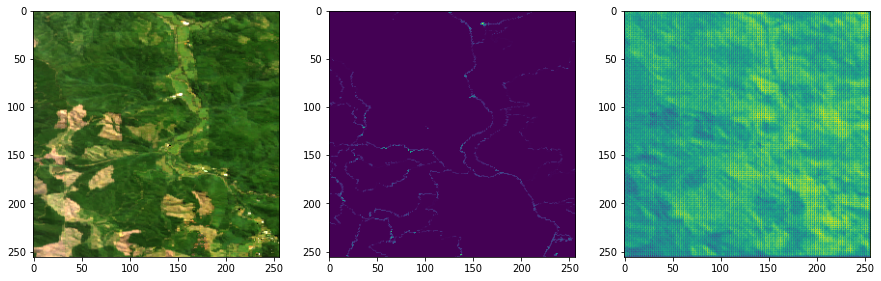

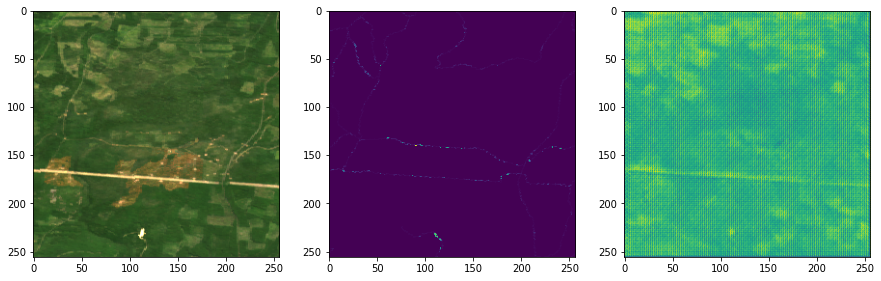

In [ ]:
ev = validation.shuffle(1024).take(5).as_numpy_iterator()
for i in ev:
  im = i[0][0][:,:,:]
  rgb = np.flip(i[0][0][:,:,1:4],axis=2) # take band 1:4 and flip it from BGR to RGB
  gt = i[1][0][:,:,0]
  pr = um.predict(i[0], verbose=1)
  fig, axs = plt.subplots(1,3,figsize=(15,5))
  axs[0].imshow(rgb*10)
  axs[1].imshow(gt)
  axs[2].imshow(pr[0][:,:,0])

* `[text]` shortly (max 5 sentences) explain which loss function you implemented for training the network and why?

> Mean squared error (MSE) is the most commonly used loss function for regression and we have a regression problem here where we have a continuous output

## Q4.2: pre-trained U-net
* `[code]` use the pre-trained model to predict the imperviousness of the validation dataset


In [ ]:
pret = tf.keras.models.load_model('/content/drive/MyDrive/geemm.h5')

In [ ]:
output = pret.predict(validation.take(10), verbose=1)

10/10 [==============================] - 11s 280ms/step


* `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model


1/1 [==============================] - 1s 626ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


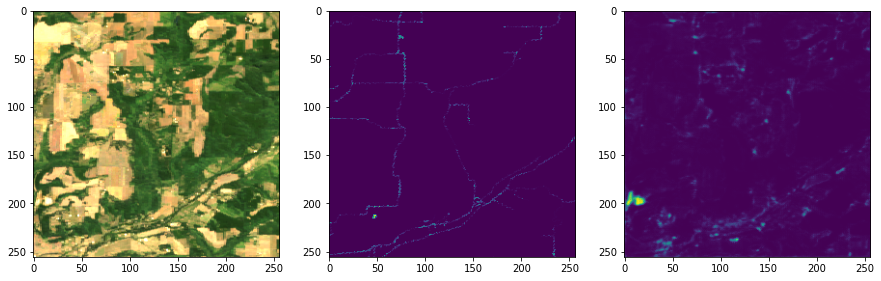

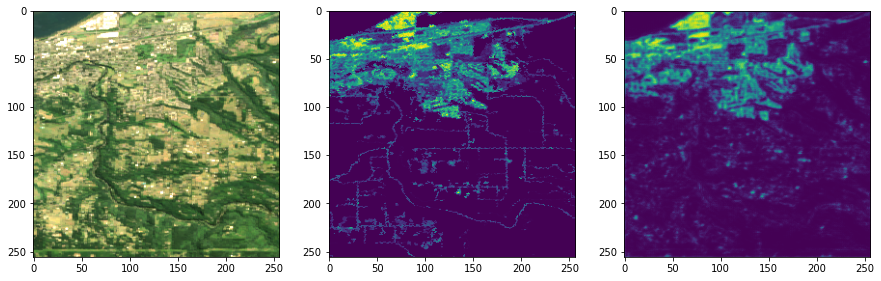

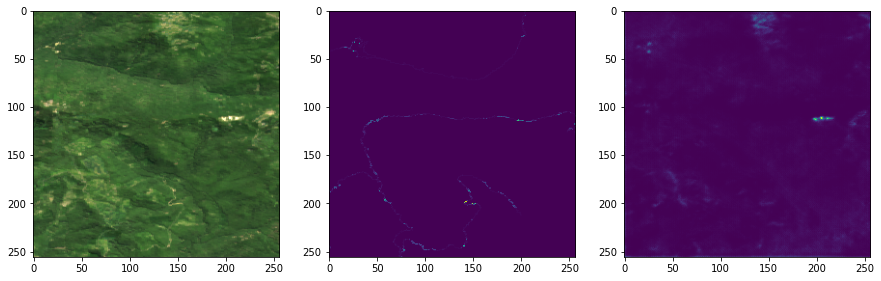

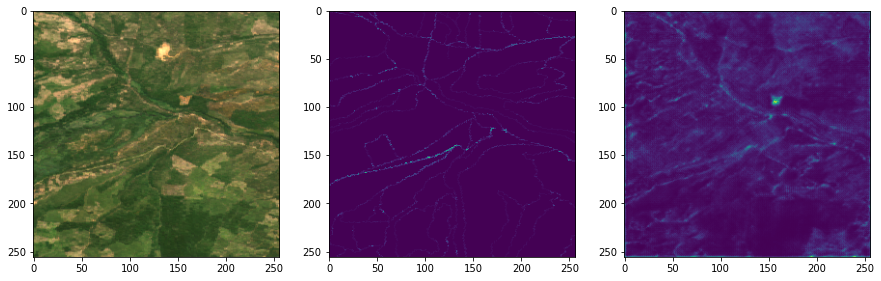

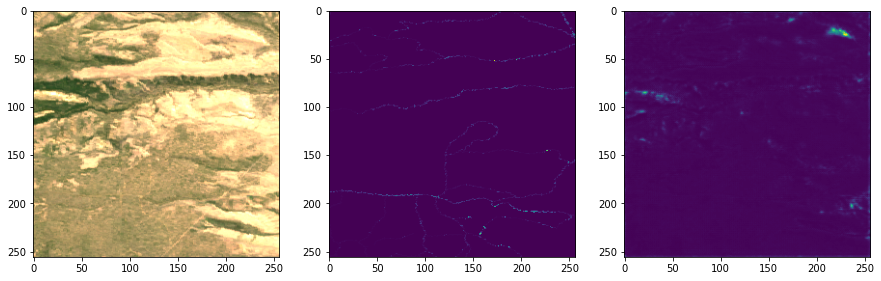

In [ ]:
ev = validation.shuffle(1024).take(5).as_numpy_iterator()
for i in ev:
  im = i[0][0][:,:,:]
  rgb = np.flip(i[0][0][:,:,1:4],axis=2) # take band 1:4 and flip it from BGR to RGB
  gt = i[1][0][:,:,0]
  pr = pret.predict(i[0], verbose=1)
  fig, axs = plt.subplots(1,3,figsize=(15,5))
  axs[0].imshow(rgb*10)
  axs[1].imshow(gt)
  axs[2].imshow(pr[0][:,:,0])

* `[text]` shortly discuss the performance of the model based on these example images (e.g., where does it seem to be ok, where not, why could that be the case)

> * Model seems to perform well over urbanized areas and larger settlements, but smaller features (e.g. roads) are often missed. This is not that bad as this small scale features are also difficult to see with the eye.
* Model shows a less binary character with more intermediate (0.2-0.8) prediction outcomes
* Bright bare ground is often confused with urbanized areas which is again not that surprising given the similar spectral characteristics.

# End
I hope you enjoy the assignment. In case of questions, please use the mattermost channel of week 7.